<a href="https://colab.research.google.com/github/jamessutton600613-png/GC/blob/main/Untitled193.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# TDSE 2D — Chain scans for H (kappa_y), I (PCET timing), E (barrier noise)
# Outputs:
#   /content/scan_H_flux.csv
#   /content/scan_I_timing_flux.csv
#   /content/scan_E_noise_flux.csv
#   /content/scan_summary.png
#   /content/optimized_params.json
#
# Each CSV has columns: parameter, total_forward_flux, peak_forward_flux, t_half
# The summary figure marks the "best" setting by Total Forward Flux (and prints it).

import sys, os, csv, json
import numpy as _np
try:
    import cupy as _cp
    _ = _cp.zeros(1); use_gpu=True; xp=_cp; print("GPU: CuPy")
except Exception as e:
    use_gpu=False; xp=_np; print("CPU: NumPy fallback", e)

import numpy as np
import matplotlib.pyplot as plt

# ---------------- basic sim knobs (kept modest for scan speed) ----------------
Nx, Ny = 256, 128
Lx, Ly = 70.0, 35.0
dx, dy = Lx/Nx, Ly/Ny
dt, n_frames, steps_per_frame = 0.08, 1200, 1   # ~96 time units; increase n_frames if needed
hbar = 1.0

# base packet & controls (same style as your main runs)
x0,y0=-20.0,0.0; kx0,ky0=1.6,0.0; sigx,sigy=3.5,4.0
E_dc_C, E0_C, w_C = 0.08, 0.14, 0.10
xwin_w_default = 6.0
tauI, E_pI, A_locI, sigI = 1.2, 0.28, 0.35, 6.0
t_arrival = (0.0 - x0)/max(kx0,1e-9); t0 = float(t_arrival)

# scan ranges
kappa_vals   = np.linspace(0.0, 0.08, 9)       # H scan
pcet_shifts  = np.linspace(-0.2, +0.2, 9)      # I scan (t0 -> t0*(1+shift))
noise_amps   = np.linspace(0.0, 0.04, 9)       # E scan

# ---------------- grid ----------------
x = xp.linspace(-Lx/2, Lx/2 - dx, Nx)
y = xp.linspace(-Ly/2, Ly/2 - dy, Ny)
X, Y = xp.meshgrid(x, y, indexing='xy')

# x=0 flux plane indices
i0 = int(round((0.0 + Lx/2)/dx))
iL, iR = max(0, i0-1), min(Nx-1, i0+1)
d_dx = 1.0/(2*dx)

# ---------------- base potential + CAP ----------------
barrier_center=0.0; barrier_width=2.0; barrier_height=0.3
pocket_x_start=10.0; pocket_depth=-15.0

V0 = xp.zeros((Ny, Nx), dtype=xp.float64)
barrier_mask = xp.abs(X-barrier_center) < (barrier_width/2)
V0 += barrier_height*barrier_mask
V0 += pocket_depth*(X>pocket_x_start)

cap_margin=8.0; eta=2.5e-4
def _cap(coord,L,margin):
    r = xp.maximum(xp.abs(coord)-(L/2 - margin),0)/margin
    return r**4
CAP = -1j*eta*(_cap(X,Lx,cap_margin)+_cap(Y,Ly,cap_margin))
V0_cap = V0 + CAP

# ---------------- packet ----------------
def make_psi0():
    psi = xp.exp(-((X-x0)**2/(2*sigx**2)+(Y-y0)**2/(2*sigy**2))).astype(xp.complex128)
    psi *= xp.exp(1j*(kx0*X+ky0*Y))
    psi /= xp.sqrt(xp.sum(xp.abs(psi)**2)*dx*dy)
    return psi

# ---------------- kinetic propagator ----------------
def make_step(dt_local, m_local=1.0):
    if use_gpu:
        kx = 2*xp.pi*_cp.fft.fftfreq(Nx, d=dx); ky = 2*xp.pi*_cp.fft.fftfreq(Ny, d=dy)
    else:
        kx = 2*xp.pi*xp.fft.fftfreq(Nx, d=dx);  ky = 2*xp.pi*xp.fft.fftfreq(Ny, d=dy)
    KX, KY = xp.meshgrid(kx, ky, indexing='xy')
    T_k = (hbar**2)*(KX**2+KY**2)/(2*m_local)
    expT = xp.exp(-1j * T_k * (dt_local/hbar))
    fft2, ifft2 = xp.fft.fft2, xp.fft.ifft2
    def step(psi, V):
        eVh = xp.exp(-1j*V*(dt_local/(2*hbar)))
        psi = psi * eVh
        psi = ifft2(fft2(psi) * expT)
        psi = psi * eVh
        return psi
    return step

# ---------------- factors ----------------
def V_C(t): return V0_cap - (E_dc_C + E0_C*xp.sin(w_C*t))*X

def V_H_factory(kappa_y, xwin_w=xwin_w_default):
    X_win = xp.exp(-(X**2)/(2*xwin_w**2))
    def V_H(t): return V0_cap + 0.5*kappa_y*(Y**2)*X_win
    return V_H

ENV_I = xp.exp(-(((X-12.0)**2 + Y**2)/(2*sigI**2))) * (X>2.0)
def gI(t, t0_eff): return xp.exp(-((t - t0_eff)**2)/(2*tauI**2))
def V_I_with_shift(t, t0_eff):
    return V0_cap - (E_pI*gI(t, t0_eff))*X - A_locI*gI(t, t0_eff)*ENV_I

# noise/temperature (E)
wE_base = xp.asarray([0.05, 0.11, 0.17], dtype=xp.float64)
aE_base = xp.asarray([0.04, 0.03, 0.02], dtype=xp.float64)
_rng = np.random.RandomState(42)
noise_field = xp.asarray(_rng.normal(0,1,(Ny,Nx))) * barrier_mask
def V_E_factory(amp):
    def V_E(t):
        harmonic = xp.sum((amp*aE_base) * xp.sin(wE_base*t))
        n = (0.5*amp)*xp.sin(0.9*t)*noise_field
        return V0_cap + harmonic*barrier_mask + n
    return V_E

# combine H+C+I(+E)
def make_combo(kappa_y=0.04, pcet_shift=0.0, noise_amp=0.0):
    V_H = V_H_factory(kappa_y)
    V_E = V_E_factory(noise_amp) if noise_amp>0 else None
    def V_combo(t):
        base = V_H(t) + V_C(t) + V_I_with_shift(t, t0*(1.0+pcet_shift)) - 2*V0_cap
        if V_E is not None:
            base = base + (V_E(t) - V0_cap)
        return base
    return V_combo

# ---------------- flux metrics ----------------
def flux_metrics(Jx, dt):
    Jpos = np.clip(Jx, 0, None)
    total_forward = float(np.trapz(Jpos, dx=dt))
    peak_forward  = float(Jpos.max())
    cumsum = np.cumsum(Jpos) * dt
    half = 0.5 * cumsum[-1] if cumsum[-1]>0 else 0.0
    t_half = float(np.interp(half, cumsum, np.arange(Jpos.size)*dt)) if half>0 else 0.0
    return total_forward, peak_forward, t_half

def run_case(V_fn, label="case", m_local=1.0):
    step = make_step(dt, m_local)
    psi = make_psi0()
    J_record = np.zeros(n_frames, dtype=np.float64)
    for n in range(n_frames):
        t = dt * n
        for _ in range(steps_per_frame):
            psi = step(psi, V_fn(t))
        dpsi_dx = (psi[:, iR] - psi[:, iL]) * d_dx
        col = psi[:, i0]
        if use_gpu:
            dpsi_dx = _cp.asnumpy(dpsi_dx); col = _cp.asnumpy(col)
        Jx = (hbar/m_local) * np.imag(col.conj()*dpsi_dx)
        J_record[n] = float(Jx.sum()*dy)
    return flux_metrics(J_record, dt)

# ---------------- scans ----------------
def run_scan(x_vals, label, build_V, csv_path):
    rows=[ [label, "total_forward_flux", "peak_forward_flux", "t_half"] ]
    for v in x_vals:
        V = build_V(float(v))
        tf, pf, th = run_case(V, label=f"{label}={v:.3f}")
        rows.append([float(v), tf, pf, th])
        print(f"[{label}] {v:.3f}  total={tf:.4g}  peak={pf:.4g}  t1/2={th:.3g}")
    with open(csv_path,"w",newline="") as f:
        w=csv.writer(f); w.writerows(rows)
    data = np.array(rows[1:], dtype=float)
    return data  # (N,4): x, total, peak, thalf

print("[Scan] H (kappa_y) ...")
data_H = run_scan(kappa_vals, "kappa_y",
                  build_V=lambda k: make_combo(kappa_y=k, pcet_shift=0.0, noise_amp=0.0),
                  csv_path="/content/scan_H_flux.csv")

print("[Scan] I (PCET timing) ...")
data_I = run_scan(pcet_shifts, "pcet_shift",
                  build_V=lambda sh: make_combo(kappa_y=0.04, pcet_shift=sh, noise_amp=0.0),
                  csv_path="/content/scan_I_timing_flux.csv")

print("[Scan] E (noise amp) ...")
data_E = run_scan(noise_amps, "noise_amp",
                  build_V=lambda amp: make_combo(kappa_y=0.04, pcet_shift=0.0, noise_amp=amp),
                  csv_path="/content/scan_E_noise_flux.csv")

# ---------------- choose optima (by total forward flux) ----------------
def choose_best(data):
    # data columns: x, total, peak, thalf
    idx = int(np.argmax(data[:,1]))
    rec = {"x": float(data[idx,0]),
           "total_forward": float(data[idx,1]),
           "peak_forward": float(data[idx,2]),
           "t_half": float(data[idx,3])}
    return rec, idx

best_H, idxH = choose_best(data_H)
best_I, idxI = choose_best(data_I)
best_E, idxE = choose_best(data_E)

print("\n=== Suggested parameters (maximize total forward flux) ===")
print(f"H funnel (kappa_y): {best_H['x']:.4f}  "
      f"(total={best_H['total_forward']:.4g}, peak={best_H['peak_forward']:.4g}, t_half={best_H['t_half']:.3g})")
print(f"I timing (t0 scale = 1+shift): shift={best_I['x']:+.3f} → t0*{1.0+best_I['x']:.3f}  "
      f"(total={best_I['total_forward']:.4g})")
print(f"E noise amplitude: {best_E['x']:.4f}  "
      f"(total={best_E['total_forward']:.4g})")

with open("/content/optimized_params.json","w") as f:
    json.dump({
        "kappa_y": best_H["x"],
        "pcet_shift": best_I["x"],
        "t0_scale": 1.0+best_I["x"],
        "noise_amp": best_E["x"],
        "notes": "Use these in make_combo(kappa_y=?, pcet_shift=?, noise_amp=?). Objective: maximize total forward flux."
    }, f, indent=2)
print("[OK] optimized_params.json written")

# ---------------- summary figure (3 panels with peaks marked) ----------------
fig, axes = plt.subplots(1,3, figsize=(12,4))
# H
ax=axes[0]
ax.plot(data_H[:,0], data_H[:,1], marker='o', label="Total")
ax.plot(data_H[:,0], data_H[:,2], marker='s', label="Peak", alpha=0.7)
ax.axvline(best_H["x"], ls='--', color='tab:red', alpha=0.8)
ax.set_title("H: funnel strength  $\\kappa_y$")
ax.set_xlabel("$\\kappa_y$")
ax.set_ylabel("flux (arb.)")
ax.grid(alpha=0.3); ax.legend()
# I
ax=axes[1]
ax.plot(data_I[:,0], data_I[:,1], marker='o', label="Total")
ax.plot(data_I[:,0], data_I[:,2], marker='s', label="Peak", alpha=0.7)
ax.axvline(best_I["x"], ls='--', color='tab:red', alpha=0.8)
ax.set_title("I: PCET timing shift  $t_0 \\to t_0(1+\\delta)$")
ax.set_xlabel("shift $\\delta$")
ax.grid(alpha=0.3); ax.legend()
# E
ax=axes[2]
ax.plot(data_E[:,0], data_E[:,1], marker='o', label="Total")
ax.plot(data_E[:,0], data_E[:,2], marker='s', label="Peak", alpha=0.7)
ax.axvline(best_E["x"], ls='--', color='tab:red', alpha=0.8)
ax.set_title("E: noise amplitude")
ax.set_xlabel("amplitude")
ax.grid(alpha=0.3); ax.legend()

fig.tight_layout()
fig.savefig("/content/scan_summary.png", dpi=300)
plt.close(fig)
print("[OK] scan_summary.png saved")

GPU: CuPy
[Scan] H (kappa_y) ...


/tmp/ipython-input-3239730516.py:132: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  total_forward = float(np.trapz(Jpos, dx=dt))


[kappa_y] 0.000  total=1.637  peak=0.337  t1/2=10.6
[kappa_y] 0.010  total=1.605  peak=0.3375  t1/2=10.5
[kappa_y] 0.020  total=1.555  peak=0.3375  t1/2=10.3
[kappa_y] 0.030  total=1.516  peak=0.337  t1/2=10.3
[kappa_y] 0.040  total=1.472  peak=0.3364  t1/2=10.2
[kappa_y] 0.050  total=1.431  peak=0.3355  t1/2=10.1
[kappa_y] 0.060  total=1.379  peak=0.3343  t1/2=10
[kappa_y] 0.070  total=1.264  peak=0.3328  t1/2=9.85
[kappa_y] 0.080  total=1.156  peak=0.3313  t1/2=9.69
[Scan] I (PCET timing) ...
[pcet_shift] -0.200  total=1.34  peak=0.3569  t1/2=9.82
[pcet_shift] -0.150  total=1.376  peak=0.3467  t1/2=9.94
[pcet_shift] -0.100  total=1.409  peak=0.3403  t1/2=10
[pcet_shift] -0.050  total=1.428  peak=0.3374  t1/2=10.1
[pcet_shift] 0.000  total=1.472  peak=0.3364  t1/2=10.2
[pcet_shift] 0.050  total=1.445  peak=0.3361  t1/2=10.1
[pcet_shift] 0.100  total=1.399  peak=0.3361  t1/2=10
[pcet_shift] 0.150  total=1.336  peak=0.3361  t1/2=9.91
[pcet_shift] 0.200  total=1.265  peak=0.3361  t1/2=9.

GPU: CuPy


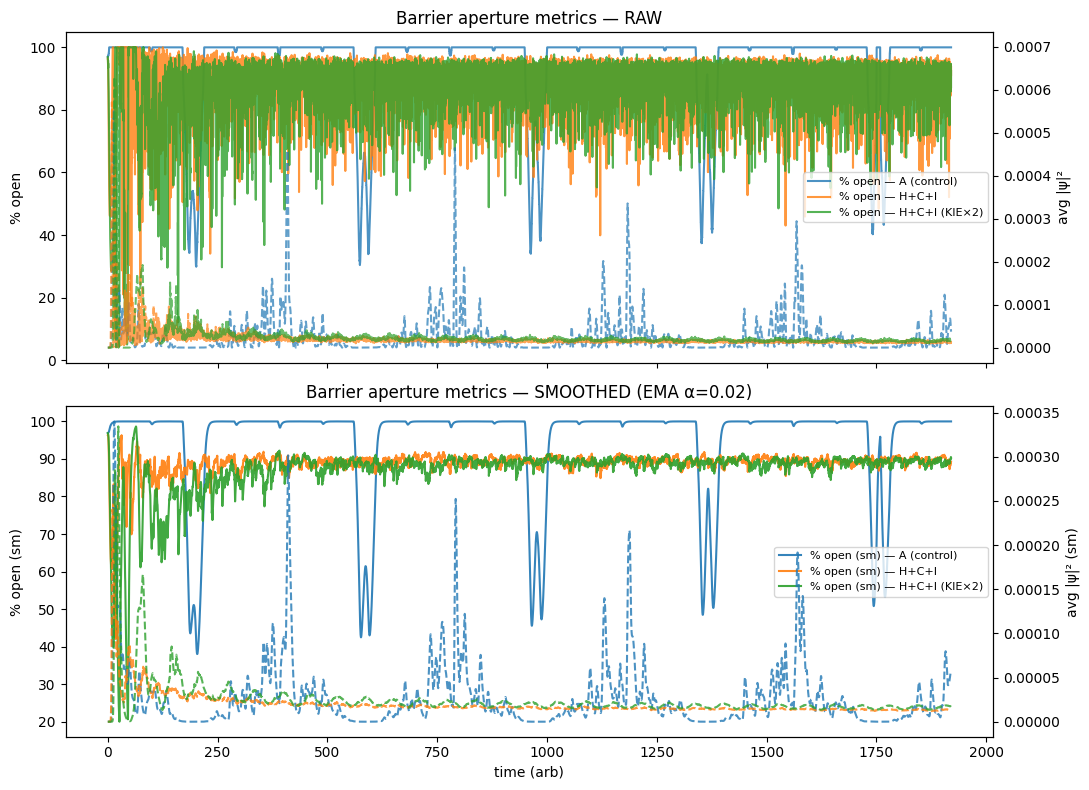

[OK] Plot saved -> /content/GQR_yz_x0_metrics_with_smooth.png
[OK] CSV saved -> /content/GQR_yz_x0_metrics_with_smooth.csv


In [ ]:
# 3D TDSE — METRICS ONLY on YZ@x=0 with RAW + SMOOTHED charts
# Cases: A (control), H+C+I, H+C+I (KIE×2)
# Saves PNG + CSV, but also displays charts inline in Colab.

import sys, csv, time
import numpy as _np
try:
    import cupy as _cp
    _ = _cp.zeros(1); xp=_cp; use_gpu=True; print("GPU: CuPy")
except Exception as e:
    xp=_np; use_gpu=False; print("CPU fallback:", e)

import numpy as np
import matplotlib.pyplot as plt

# ---------------- Simulation knobs ----------------
Nx, Ny, Nz = 192, 128, 128
Lx, Ly, Lz = 70.0, 35.0, 35.0
dx, dy, dz = Lx/Nx, Ly/Ny, Lz/Nz
dt, n_frames, steps_per_frame = 0.08, 24000, 1   # shorter for test
times = np.arange(n_frames)*dt

# ---------------- Domain ----------------
x = xp.linspace(-Lx/2, Lx/2 - dx, Nx)
y = xp.linspace(-Ly/2, Ly/2 - dy, Ny)
z = xp.linspace(-Lz/2, Lz/2 - dz, Nz)
Z, Y, X = xp.meshgrid(z, y, x, indexing='ij')
hbar = 1.0

ix0 = int(round((0.0 + Lx/2)/dx))  # x=0 slice index

# ---------------- Potentials ----------------
barrier_center=0.0; barrier_width=2.0; barrier_height=0.3
pocket_x_start=10.0; pocket_depth=-15.0
V0 = xp.zeros((Nz, Ny, Nx), dtype=xp.float64)
barrier_mask = xp.abs(X - barrier_center) < (barrier_width/2)
V0 += barrier_height*barrier_mask
V0 += pocket_depth*(X>pocket_x_start)
cap_margin=8.0; eta=2.5e-4
def _cap(coord,L,margin): r = xp.maximum(xp.abs(coord)-(L/2 - margin),0)/margin; return r**4
CAP = -1j*eta*(_cap(X,Lx,cap_margin)+_cap(Y,Ly,cap_margin)+_cap(Z,Lz,cap_margin))
V0_cap = V0 + CAP

def V_A(t): return V0_cap
E_dc_C, E0_C, w_C = 0.08, 0.14, 0.10
def V_C(t): return V0_cap - (E_dc_C + E0_C*xp.sin(w_C*t))*X
kappa=0.04; xwin_w=6.0
X_win = xp.exp(-(X**2)/(2*xwin_w**2))
def V_H(t): return V0_cap + 0.5*kappa*(Y**2+Z**2)*X_win
x0,y0,z0=-20.0,0.0,0.0; kx0,ky0,kz0=1.6,0.0,0.0; sigx,sigy,sigz=3.5,4.0,4.0
t_arrival=(0.0-x0)/max(kx0,1e-9); t0=float(t_arrival)
tauI,E_pI,A_locI,sigI=1.2,0.28,0.35,6.0
ENV_I = xp.exp(-(((X-12.0)**2+Y**2+Z**2)/(2*sigI**2)))*(X>2.0)
def gI(t): return xp.exp(-((t-t0)**2)/(2*tauI**2))
def V_I(t): return V0_cap - (E_pI*gI(t))*X - A_locI*gI(t)*ENV_I
def V_HCI(t): return V_H(t)+V_C(t)+V_I(t)-2*V0_cap

# ---------------- Initial packet ----------------
def make_psi0():
    G = xp.exp(-(((X-x0)**2)/(2*sigx**2)+((Y-y0)**2)/(2*sigy**2)+((Z-z0)**2)/(2*sigz**2)))
    psi = G.astype(xp.complex128)*xp.exp(1j*(kx0*X+ky0*Y+kz0*Z))
    psi /= xp.sqrt(xp.sum(xp.abs(psi)**2)*dx*dy*dz)
    return psi

# ---------------- Split-operator ----------------
def make_step(m_local):
    kx = 2*xp.pi*( _cp.fft.fftfreq(Nx, d=dx) if use_gpu else xp.fft.fftfreq(Nx,d=dx) )
    ky = 2*xp.pi*( _cp.fft.fftfreq(Ny, d=dy) if use_gpu else xp.fft.fftfreq(Ny,d=dy) )
    kz = 2*xp.pi*( _cp.fft.fftfreq(Nz, d=dz) if use_gpu else xp.fft.fftfreq(Nz,d=dz) )
    KZ,KY,KX=xp.meshgrid(kz,ky,kx,indexing='ij')
    T_k=(hbar**2)*(KX**2+KY**2+KZ**2)/(2*m_local)
    expT=xp.exp(-1j*T_k*(dt/hbar))
    def step(psi,V):
        eVh=xp.exp(-1j*V*(dt/(2*hbar))); psi=psi*eVh
        psi=xp.fft.ifftn(xp.fft.fftn(psi)*expT); return psi*eVh
    return step

# ---------------- Cases ----------------
cases=[
 {"name":"A (control)","V":V_A,"m":1.0,"psi":make_psi0(),"step":None},
 {"name":"H+C+I","V":V_HCI,"m":1.0,"psi":make_psi0(),"step":None},
 {"name":"H+C+I (KIE×2)","V":V_HCI,"m":2.0,"psi":make_psi0(),"step":None},
]
for c in cases: c["step"]=make_step(c["m"])

# ---------------- Metrics: central 50% disk ----------------
y_host=_cp.asnumpy(y) if use_gpu else y
z_host=_cp.asnumpy(z) if use_gpu else z
Yg,Zg=np.meshgrid(y_host,z_host,indexing='ij')
Rnorm=np.sqrt((Yg/(Ly/2))**2+(Zg/(Lz/2))**2)
mask_central=Rnorm<=0.5
pct_open=[np.zeros(n_frames) for _ in cases]
avg_prob=[np.zeros(n_frames) for _ in cases]
THRESH_FRAC=0.01

# ---------------- Run ----------------
for n in range(n_frames):
    t=dt*n
    for ci,c in enumerate(cases):
        psi=c["psi"]
        psi=c["step"](psi,c["V"](t))
        c["psi"]=psi
        yz=(xp.abs(psi)**2)[:,:,ix0].T
        yz_h=_cp.asnumpy(yz) if use_gpu else yz
        region=yz_h[mask_central]
        if region.size>0:
            pmax=region.max()
            thr=THRESH_FRAC*pmax
            pct_open[ci][n]=100.0*(region>=thr).sum()/region.size if pmax>0 else 0
            avg_prob[ci][n]=region.mean()
        else:
            pct_open[ci][n]=0; avg_prob[ci][n]=0

# ---------------- Smoothing ----------------
def smooth_ema(data,alpha=0.02):
    sm=np.zeros_like(data); sm[0]=data[0]
    for i in range(1,len(data)): sm[i]=alpha*data[i]+(1-alpha)*sm[i-1]
    return sm
pct_open_sm=[smooth_ema(arr) for arr in pct_open]
avg_prob_sm=[smooth_ema(arr) for arr in avg_prob]

# ---------------- Plot ----------------
fig,(ax_raw,ax_sm)=plt.subplots(2,1,figsize=(11,8),sharex=True)

ax_raw2=ax_raw.twinx()
for ci,c in enumerate(cases):
    ax_raw.plot(times,pct_open[ci],color=f"C{ci}",alpha=0.8,label=f"% open — {c['name']}")
    ax_raw2.plot(times,avg_prob[ci],color=f"C{ci}",ls="--",alpha=0.7,label=f"avg|ψ|² — {c['name']}")
ax_raw.set_ylabel("% open")
ax_raw2.set_ylabel("avg |ψ|²")
ax_raw.set_title("Barrier aperture metrics — RAW")
ax_raw.legend(loc="center right",fontsize=8)

ax_sm2=ax_sm.twinx()
for ci,c in enumerate(cases):
    ax_sm.plot(times,pct_open_sm[ci],color=f"C{ci}",alpha=0.9,label=f"% open (sm) — {c['name']}")
    ax_sm2.plot(times,avg_prob_sm[ci],color=f"C{ci}",ls="--",alpha=0.8,label=f"avg|ψ|² (sm) — {c['name']}")
ax_sm.set_xlabel("time (arb)")
ax_sm.set_ylabel("% open (sm)")
ax_sm2.set_ylabel("avg |ψ|² (sm)")
ax_sm.set_title("Barrier aperture metrics — SMOOTHED (EMA α=0.02)")
ax_sm.legend(loc="center right",fontsize=8)

fig.tight_layout()
plt.show()  # show inline in Colab

png_path="/content/GQR_yz_x0_metrics_with_smooth.png"
fig.savefig(png_path,dpi=240)
print(f"[OK] Plot saved -> {png_path}")

# ---------------- CSV ----------------
csv_path="/content/GQR_yz_x0_metrics_with_smooth.csv"
with open(csv_path,"w",newline="") as f:
    w=csv.writer(f)
    header=["t"]
    for c in cases: header += [f"%open_{c['name']}",f"avgpsi2_{c['name']}",
                               f"%open_sm_{c['name']}",f"avgpsi2_sm_{c['name']}"]
    w.writerow(header)
    for i,t in enumerate(times):
        row=[t]
        for ci,_ in enumerate(cases):
            row += [pct_open[ci][i],avg_prob[ci][i],
                    pct_open_sm[ci][i],avg_prob_sm[ci][i]]
        w.writerow(row)
print(f"[OK] CSV saved -> {csv_path}")

GPU: CuPy
[Run] 10%
[Run] 20%
[Run] 30%
[Run] 40%
[Run] 50%
[Run] 60%
[Run] 70%
[Run] 80%
[Run] 90%


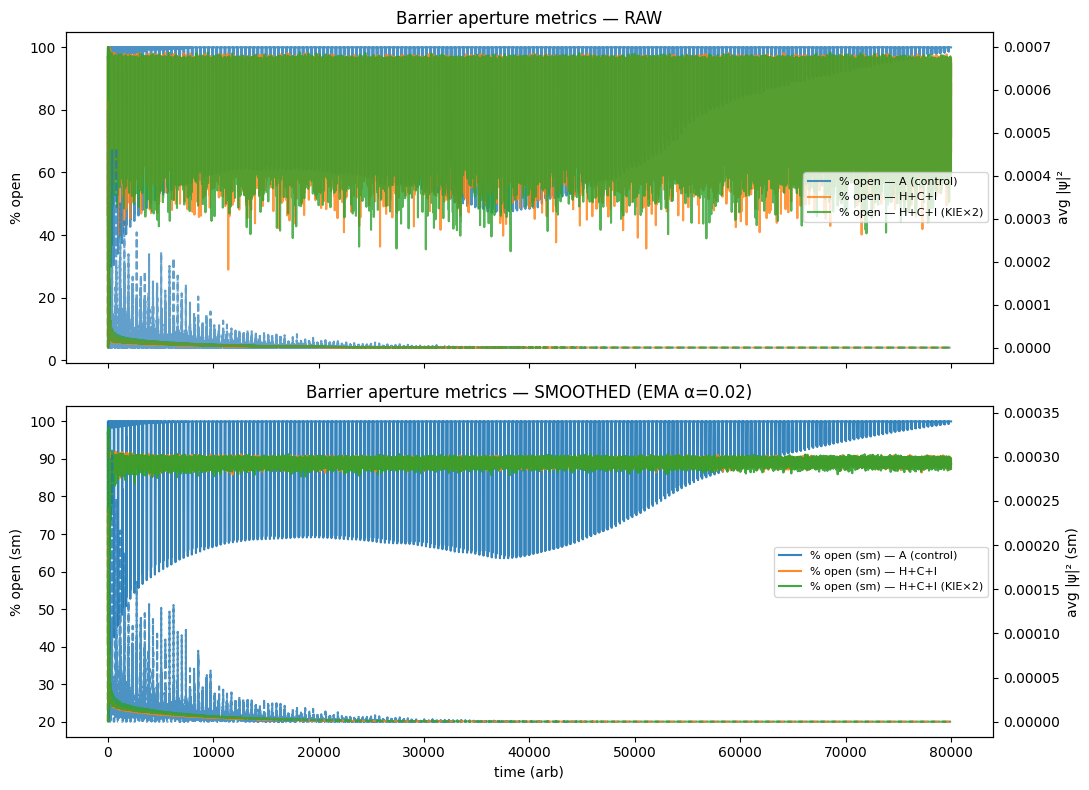

[OK] Plot saved -> /content/GQR_yz_x0_metrics_with_smooth.png
[OK] CSV saved -> /content/GQR_yz_x0_metrics_with_smooth.csv


In [ ]:
# 3D TDSE — METRICS ONLY on YZ@x=0 with RAW + SMOOTHED charts
# Cases: A (control), H+C+I, H+C+I (KIE×2)
# Saves PNG + CSV, but also displays charts inline in Colab.
# Now includes % progress logging.

import sys, csv, time
import numpy as _np
try:
    import cupy as _cp
    _ = _cp.zeros(1); xp=_cp; use_gpu=True; print("GPU: CuPy")
except Exception as e:
    xp=_np; use_gpu=False; print("CPU fallback:", e)

import numpy as np
import matplotlib.pyplot as plt

# ---------------- Simulation knobs ----------------
Nx, Ny, Nz = 192, 128, 128
Lx, Ly, Lz = 70.0, 35.0, 35.0
dx, dy, dz = Lx/Nx, Ly/Ny, Lz/Nz
dt, n_frames, steps_per_frame = 0.08, 1000000, 1   # shorter for test
times = np.arange(n_frames)*dt

# ---------------- Domain ----------------
x = xp.linspace(-Lx/2, Lx/2 - dx, Nx)
y = xp.linspace(-Ly/2, Ly/2 - dy, Ny)
z = xp.linspace(-Lz/2, Lz/2 - dz, Nz)
Z, Y, X = xp.meshgrid(z, y, x, indexing='ij')
hbar = 1.0
ix0 = int(round((0.0 + Lx/2)/dx))  # x=0 slice index

# ---------------- Potentials ----------------
barrier_center=0.0; barrier_width=2.0; barrier_height=0.3
pocket_x_start=10.0; pocket_depth=-15.0
V0 = xp.zeros((Nz, Ny, Nx), dtype=xp.float64)
barrier_mask = xp.abs(X - barrier_center) < (barrier_width/2)
V0 += barrier_height*barrier_mask
V0 += pocket_depth*(X>pocket_x_start)
cap_margin=8.0; eta=2.5e-4
def _cap(coord,L,margin): r = xp.maximum(xp.abs(coord)-(L/2 - margin),0)/margin; return r**4
CAP = -1j*eta*(_cap(X,Lx,cap_margin)+_cap(Y,Ly,cap_margin)+_cap(Z,Lz,cap_margin))
V0_cap = V0 + CAP

def V_A(t): return V0_cap
E_dc_C, E0_C, w_C = 0.08, 0.14, 0.10
def V_C(t): return V0_cap - (E_dc_C + E0_C*xp.sin(w_C*t))*X
kappa=0.04; xwin_w=6.0
X_win = xp.exp(-(X**2)/(2*xwin_w**2))
def V_H(t): return V0_cap + 0.5*kappa*(Y**2+Z**2)*X_win
x0,y0,z0=-20.0,0.0,0.0; kx0,ky0,kz0=1.6,0.0,0.0; sigx,sigy,sigz=3.5,4.0,4.0
t_arrival=(0.0-x0)/max(kx0,1e-9); t0=float(t_arrival)
tauI,E_pI,A_locI,sigI=1.2,0.28,0.35,6.0
ENV_I = xp.exp(-(((X-12.0)**2+Y**2+Z**2)/(2*sigI**2)))*(X>2.0)
def gI(t): return xp.exp(-((t-t0)**2)/(2*tauI**2))
def V_I(t): return V0_cap - (E_pI*gI(t))*X - A_locI*gI(t)*ENV_I
def V_HCI(t): return V_H(t)+V_C(t)+V_I(t)-2*V0_cap

# ---------------- Initial packet ----------------
def make_psi0():
    G = xp.exp(-(((X-x0)**2)/(2*sigx**2)+((Y-y0)**2)/(2*sigy**2)+((Z-z0)**2)/(2*sigz**2)))
    psi = G.astype(xp.complex128)*xp.exp(1j*(kx0*X+ky0*Y+kz0*Z))
    psi /= xp.sqrt(xp.sum(xp.abs(psi)**2)*dx*dy*dz)
    return psi

# ---------------- Split-operator ----------------
def make_step(m_local):
    kx = 2*xp.pi*( _cp.fft.fftfreq(Nx, d=dx) if use_gpu else xp.fft.fftfreq(Nx,d=dx) )
    ky = 2*xp.pi*( _cp.fft.fftfreq(Ny, d=dy) if use_gpu else xp.fft.fftfreq(Ny,d=dy) )
    kz = 2*xp.pi*( _cp.fft.fftfreq(Nz, d=dz) if use_gpu else xp.fft.fftfreq(Nz,d=dz) )
    KZ,KY,KX=xp.meshgrid(kz,ky,kx,indexing='ij')
    T_k=(hbar**2)*(KX**2+KY**2+KZ**2)/(2*m_local)
    expT=xp.exp(-1j*T_k*(dt/hbar))
    def step(psi,V):
        eVh=xp.exp(-1j*V*(dt/(2*hbar))); psi=psi*eVh
        psi=xp.fft.ifftn(xp.fft.fftn(psi)*expT); return psi*eVh
    return step

# ---------------- Cases ----------------
cases=[
 {"name":"A (control)","V":V_A,"m":1.0,"psi":make_psi0(),"step":None},
 {"name":"H+C+I","V":V_HCI,"m":1.0,"psi":make_psi0(),"step":None},
 {"name":"H+C+I (KIE×2)","V":V_HCI,"m":2.0,"psi":make_psi0(),"step":None},
]
for c in cases: c["step"]=make_step(c["m"])

# ---------------- Metrics: central 50% disk ----------------
y_host=_cp.asnumpy(y) if use_gpu else y
z_host=_cp.asnumpy(z) if use_gpu else z
Yg,Zg=np.meshgrid(y_host,z_host,indexing='ij')
Rnorm=np.sqrt((Yg/(Ly/2))**2+(Zg/(Lz/2))**2)
mask_central=Rnorm<=0.5
pct_open=[np.zeros(n_frames) for _ in cases]
avg_prob=[np.zeros(n_frames) for _ in cases]
THRESH_FRAC=0.01

# ---------------- Run with % logging ----------------
progress_marks={int(n_frames*p/10) for p in range(1,10)}

for n in range(n_frames):
    t=dt*n
    if n in progress_marks:
        print(f"[Run] {int(100*n/n_frames)}%")
    for ci,c in enumerate(cases):
        psi=c["psi"]
        psi=c["step"](psi,c["V"](t))
        c["psi"]=psi
        yz=(xp.abs(psi)**2)[:,:,ix0].T
        yz_h=_cp.asnumpy(yz) if use_gpu else yz
        region=yz_h[mask_central]
        if region.size>0:
            pmax=region.max()
            thr=THRESH_FRAC*pmax
            pct_open[ci][n]=100.0*(region>=thr).sum()/region.size if pmax>0 else 0
            avg_prob[ci][n]=region.mean()
        else:
            pct_open[ci][n]=0; avg_prob[ci][n]=0

# ---------------- Smoothing ----------------
def smooth_ema(data,alpha=0.02):
    sm=np.zeros_like(data); sm[0]=data[0]
    for i in range(1,len(data)): sm[i]=alpha*data[i]+(1-alpha)*sm[i-1]
    return sm
pct_open_sm=[smooth_ema(arr) for arr in pct_open]
avg_prob_sm=[smooth_ema(arr) for arr in avg_prob]

# ---------------- Plot ----------------
fig,(ax_raw,ax_sm)=plt.subplots(2,1,figsize=(11,8),sharex=True)

ax_raw2=ax_raw.twinx()
for ci,c in enumerate(cases):
    ax_raw.plot(times,pct_open[ci],color=f"C{ci}",alpha=0.8,label=f"% open — {c['name']}")
    ax_raw2.plot(times,avg_prob[ci],color=f"C{ci}",ls="--",alpha=0.7,label=f"avg|ψ|² — {c['name']}")
ax_raw.set_ylabel("% open"); ax_raw2.set_ylabel("avg |ψ|²")
ax_raw.set_title("Barrier aperture metrics — RAW")
ax_raw.legend(loc="center right",fontsize=8)

ax_sm2=ax_sm.twinx()
for ci,c in enumerate(cases):
    ax_sm.plot(times,pct_open_sm[ci],color=f"C{ci}",alpha=0.9,label=f"% open (sm) — {c['name']}")
    ax_sm2.plot(times,avg_prob_sm[ci],color=f"C{ci}",ls="--",alpha=0.8,label=f"avg|ψ|² (sm) — {c['name']}")
ax_sm.set_xlabel("time (arb)"); ax_sm.set_ylabel("% open (sm)"); ax_sm2.set_ylabel("avg |ψ|² (sm)")
ax_sm.set_title("Barrier aperture metrics — SMOOTHED (EMA α=0.02)")
ax_sm.legend(loc="center right",fontsize=8)

fig.tight_layout()
plt.show()  # show inline in Colab

png_path="/content/GQR_yz_x0_metrics_with_smooth.png"
fig.savefig(png_path,dpi=240)
print(f"[OK] Plot saved -> {png_path}")

# ---------------- CSV ----------------
csv_path="/content/GQR_yz_x0_metrics_with_smooth.csv"
with open(csv_path,"w",newline="") as f:
    w=csv.writer(f)
    header=["t"]
    for c in cases: header += [f"%open_{c['name']}",f"avgpsi2_{c['name']}",
                               f"%open_sm_{c['name']}",f"avgpsi2_sm_{c['name']}"]
    w.writerow(header)
    for i,t in enumerate(times):
        row=[t]
        for ci,_ in enumerate(cases):
            row += [pct_open[ci][i],avg_prob[ci][i],
                    pct_open_sm[ci][i],avg_prob_sm[ci][i]]
        w.writerow(row)
print(f"[OK] CSV saved -> {csv_path}")

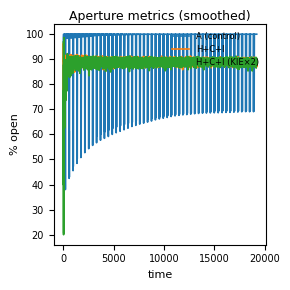

In [ ]:
# Compact Nature-style inset redraw of aperture metrics
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(3.0,3.0))  # small square
for ci,c in enumerate(cases):
    ax.plot(times, pct_open_sm[ci], lw=1.2, label=c["name"], color=f"C{ci}")
ax.set_xlabel("time", fontsize=8)
ax.set_ylabel("% open", fontsize=8)
ax.tick_params(axis="both", labelsize=7)
ax.set_title("Aperture metrics (smoothed)", fontsize=9, pad=3)

# Minimal legend inside
ax.legend(fontsize=6, loc="upper right", frameon=False)

fig.tight_layout()
plt.show()

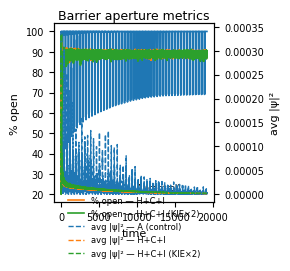

In [ ]:
# Compact Nature-style square plot with both %open and avg|ψ|²
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(3.0,3.0))

# second axis for avg|ψ|²
ax2 = ax1.twinx()

for ci, c in enumerate(cases):
    ax1.plot(times, pct_open_sm[ci], lw=1.2, color=f"C{ci}", label=f"% open — {c['name']}")
    ax2.plot(times, avg_prob_sm[ci], lw=1.0, ls="--", color=f"C{ci}", label=f"avg |ψ|² — {c['name']}")

ax1.set_xlabel("time", fontsize=8)
ax1.set_ylabel("% open", fontsize=8)
ax2.set_ylabel("avg |ψ|²", fontsize=8)

ax1.tick_params(axis="both", labelsize=7)
ax2.tick_params(axis="both", labelsize=7)

ax1.set_title("Barrier aperture metrics", fontsize=9, pad=3)

# combined legend, placed lower center
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1+lines2, labels1+labels2, fontsize=6,
           loc="lower center", bbox_to_anchor=(0.5,-0.35),
           ncol=1, frameon=False)

fig.tight_layout()
plt.show()

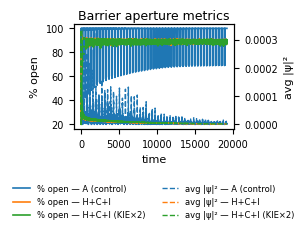

In [ ]:
# Compact Nature-style square plot with lowered legend
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(3.0,3.0))
ax2 = ax1.twinx()

# Plot both %open (solid) and avg|ψ|² (dashed)
for ci, c in enumerate(cases):
    ax1.plot(times, pct_open_sm[ci], lw=1.2, color=f"C{ci}", label=f"% open — {c['name']}")
    ax2.plot(times, avg_prob_sm[ci], lw=1.0, ls="--", color=f"C{ci}", label=f"avg |ψ|² — {c['name']}")

ax1.set_xlabel("time", fontsize=8)
ax1.set_ylabel("% open", fontsize=8)
ax2.set_ylabel("avg |ψ|²", fontsize=8)

ax1.tick_params(axis="both", labelsize=7)
ax2.tick_params(axis="both", labelsize=7)

ax1.set_title("Barrier aperture metrics", fontsize=9, pad=3)

# Merge legends and move well below the chart
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1+lines2, labels1+labels2,
           fontsize=6, loc="upper center",
           bbox_to_anchor=(0.5, -0.45),  # lower still
           ncol=2, frameon=False)

fig.tight_layout()
plt.show()

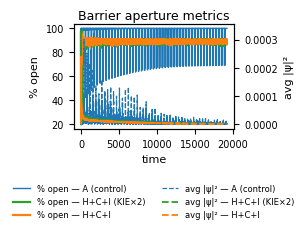

In [ ]:
# Compact Nature-style square plot with emphasized orange (H+C+I)
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(3.0,3.0))
ax2 = ax1.twinx()

# order cases so H+C+I (orange, C1) is drawn last
order = [0, 2, 1]  # control, KIE, then H+C+I on top

for ci in order:
    c = cases[ci]
    lw_main = 1.6 if "H+C+I" in c["name"] else 1.0
    lw_aux  = 1.3 if "H+C+I" in c["name"] else 0.9
    ax1.plot(times, pct_open_sm[ci], lw=lw_main,
             color=f"C{ci}", label=f"% open — {c['name']}")
    ax2.plot(times, avg_prob_sm[ci], lw=lw_aux, ls="--",
             color=f"C{ci}", label=f"avg |ψ|² — {c['name']}")

ax1.set_xlabel("time", fontsize=8)
ax1.set_ylabel("% open", fontsize=8)
ax2.set_ylabel("avg |ψ|²", fontsize=8)

ax1.tick_params(axis="both", labelsize=7)
ax2.tick_params(axis="both", labelsize=7)

ax1.set_title("Barrier aperture metrics", fontsize=9, pad=3)

# Merge legends and place below
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1+lines2, labels1+labels2,
           fontsize=6, loc="upper center",
           bbox_to_anchor=(0.5, -0.45),
           ncol=2, frameon=False)

fig.tight_layout()
plt.show()

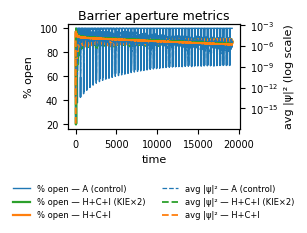

In [ ]:
# Nature-style square plot with emphasized orange (H+C+I)
# Avg |ψ|² shown on log scale (semilog y-axis on the right)

import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(3.0,3.0))
ax2 = ax1.twinx()

# plot order → H+C+I last (orange on top)
order = [0, 2, 1]

for ci in order:
    c = cases[ci]
    lw_main = 1.6 if "H+C+I" in c["name"] else 1.0
    lw_aux  = 1.3 if "H+C+I" in c["name"] else 0.9
    ax1.plot(times, pct_open_sm[ci], lw=lw_main,
             color=f"C{ci}", label=f"% open — {c['name']}")
    ax2.semilogy(times, avg_prob_sm[ci], lw=lw_aux, ls="--",
                 color=f"C{ci}", label=f"avg |ψ|² — {c['name']}")

ax1.set_xlabel("time", fontsize=8)
ax1.set_ylabel("% open", fontsize=8)
ax2.set_ylabel("avg |ψ|² (log scale)", fontsize=8)

ax1.tick_params(axis="both", labelsize=7)
ax2.tick_params(axis="both", labelsize=7)

ax1.set_title("Barrier aperture metrics", fontsize=9, pad=3)

# merge legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1+lines2, labels1+labels2,
           fontsize=6, loc="upper center",
           bbox_to_anchor=(0.5, -0.45),
           ncol=2, frameon=False)

fig.tight_layout()
plt.show()

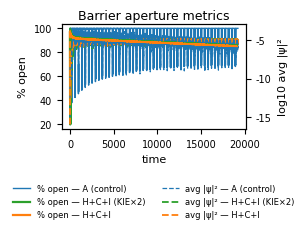

In [ ]:
# Nature-style square plot with emphasized orange (H+C+I)
# Avg |ψ|² shown on log10 scale with plain -3, -4 ticks (no 10^ notation)

import matplotlib.ticker as mticker
import matplotlib.pyplot as plt
import numpy as np

fig, ax1 = plt.subplots(figsize=(3.0,3.0))
ax2 = ax1.twinx()

order = [0, 2, 1]  # plot H+C+I last (orange on top)

for ci in order:
    c = cases[ci]
    lw_main = 1.6 if "H+C+I" in c["name"] else 1.0
    lw_aux  = 1.3 if "H+C+I" in c["name"] else 0.9
    # % open (linear)
    ax1.plot(times, pct_open_sm[ci], lw=lw_main,
             color=f"C{ci}", label=f"% open — {c['name']}")
    # avg |ψ|² (log10)
    ax2.plot(times, np.log10(avg_prob_sm[ci]+1e-16), lw=lw_aux, ls="--",
             color=f"C{ci}", label=f"avg |ψ|² — {c['name']}")

ax1.set_xlabel("time", fontsize=8)
ax1.set_ylabel("% open", fontsize=8)
ax2.set_ylabel("log10 avg |ψ|²", fontsize=8)

ax1.tick_params(axis="both", labelsize=7)
ax2.tick_params(axis="both", labelsize=7)

# custom ticks on right axis: show -1, -2, -3...
ax2.yaxis.set_major_formatter(mticker.FormatStrFormatter("%d"))

ax1.set_title("Barrier aperture metrics", fontsize=9, pad=3)

# merge legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1+lines2, labels1+labels2,
           fontsize=6, loc="upper center",
           bbox_to_anchor=(0.5, -0.45),
           ncol=2, frameon=False)

fig.tight_layout()
plt.show()

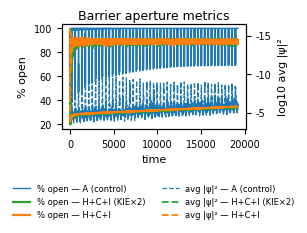

In [ ]:
# Nature-style square plot with inverted RHS scale
# Avg |ψ|² shown on log10 scale, ticks as -1, -2, -3… (not 10^)

import matplotlib.ticker as mticker
import matplotlib.pyplot as plt
import numpy as np

fig, ax1 = plt.subplots(figsize=(3.0,3.0))
ax2 = ax1.twinx()

order = [0, 2, 1]  # plot H+C+I last (orange on top)

for ci in order:
    c = cases[ci]
    lw_main = 1.6 if "H+C+I" in c["name"] else 1.0
    lw_aux  = 1.3 if "H+C+I" in c["name"] else 0.9
    # % open (linear, left axis)
    ax1.plot(times, pct_open_sm[ci], lw=lw_main,
             color=f"C{ci}", label=f"% open — {c['name']}")
    # avg |ψ|² (log10, right axis)
    ax2.plot(times, np.log10(avg_prob_sm[ci]+1e-16), lw=lw_aux, ls="--",
             color=f"C{ci}", label=f"avg |ψ|² — {c['name']}")

ax1.set_xlabel("time", fontsize=8)
ax1.set_ylabel("% open", fontsize=8)
ax2.set_ylabel("log10 avg |ψ|²", fontsize=8)

ax1.tick_params(axis="both", labelsize=7)
ax2.tick_params(axis="both", labelsize=7)

# Format right-hand ticks as integers (-1, -2, …)
ax2.yaxis.set_major_formatter(mticker.FormatStrFormatter("%d"))
# Invert right-hand axis so higher probs (closer to -1) are at top
ax2.invert_yaxis()

ax1.set_title("Barrier aperture metrics", fontsize=9, pad=3)

# merge legends and place lower
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1+lines2, labels1+labels2,
           fontsize=6, loc="upper center",
           bbox_to_anchor=(0.5, -0.45),
           ncol=2, frameon=False)

fig.tight_layout()
plt.show()

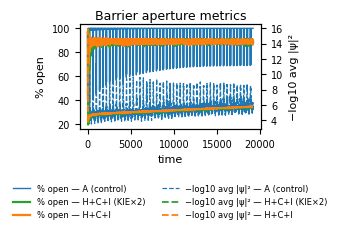

In [ ]:
# Compact square with emphasized orange; right axis uses −log10 so "up = stronger"
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np

fig, ax1 = plt.subplots(figsize=(3.0,3.0))
ax2 = ax1.twinx()

order = [0, 2, 1]  # draw H+C+I last (orange on top)

eps = 1e-16
for ci in order:
    c = cases[ci]
    lw_main = 1.6 if "H+C+I" in c["name"] else 1.0
    lw_aux  = 1.3 if "H+C+I" in c["name"] else 0.9
    # % open (left, linear)
    ax1.plot(times, pct_open_sm[ci], lw=lw_main, color=f"C{ci}",
             label=f"% open — {c['name']}")
    # −log10(avg |ψ|²) (right, linear) → larger density = higher curve
    ax2.plot(times, -np.log10(avg_prob_sm[ci] + eps), lw=lw_aux, ls="--",
             color=f"C{ci}", label=f"−log10 avg |ψ|² — {c['name']}")

ax1.set_xlabel("time", fontsize=8)
ax1.set_ylabel("% open", fontsize=8)
ax2.set_ylabel("−log10 avg |ψ|²", fontsize=8)

# tidy ticks
ax1.tick_params(axis="both", labelsize=7)
ax2.tick_params(axis="both", labelsize=7)
ax2.yaxis.set_major_locator(mticker.MaxNLocator(integer=True))  # 1,2,3...

ax1.set_title("Barrier aperture metrics", fontsize=9, pad=3)

# merged legend, lowered
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1+lines2, labels1+labels2,
           fontsize=6, loc="upper center",
           bbox_to_anchor=(0.5, -0.45), ncol=2, frameon=False)

fig.tight_layout()
plt.show()